In [467]:
'''import yfinance as yf
from datetime import datetime
import pandas as pd

# Define the ticker and date range
ticker = 'ZOMATO.NS'
start_date = '2024-01-01'
end_date = '2024-12-09'
#end_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date

# Download the data
df = yf.download(ticker, start=start_date, end=end_date)
data=pd.DataFrame(df)
print(data.head())
data.to_csv('Zomato_Data.csv')
df.dropna()
# Display the data
print(df.tail(15)) '''
import pandas as pd
df=pd.read_csv("Zomato_Data.csv")
df.columns
df=df.dropna()
print(df.head(2))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)





         Date   Adj Close       Close        High         Low        Open  \
0  2024-01-01  124.500000  124.500000  125.599998  122.849998  124.449997   
1  2024-01-02  128.699997  128.699997  129.449997  125.500000  127.000000   

     Volume  
0  24228685  
1  69395959  


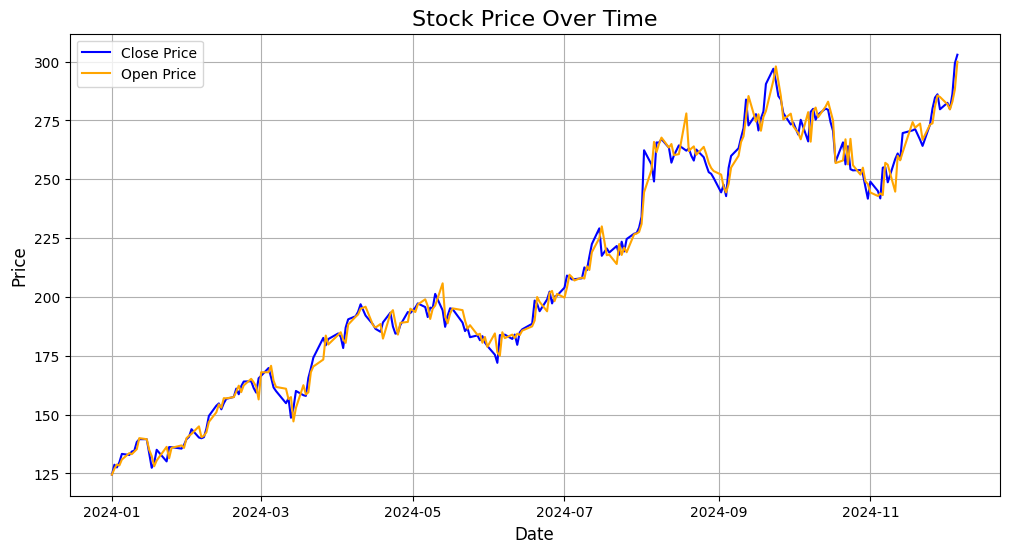

In [468]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure numeric values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')

# Handle missing values
df = df.dropna(subset=['Close', 'Open'])

# Set 'Date' as index if not already done
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
    df.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['Open'], label='Open Price', color='orange')
plt.title('Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


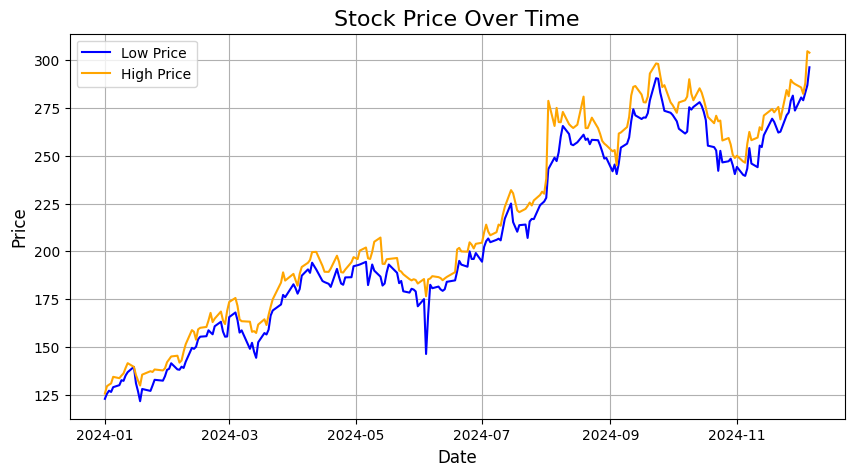

In [469]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure numeric values
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')

# Handle missing values
df = df.dropna(subset=['Low', 'High'])

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['Low'], label='Low Price', color='blue')
plt.plot(df['High'], label='High Price', color='orange')
plt.title('Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [470]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['Close'])
print("ADF Statics : ",result[0])
print("p-value : ",result[1])
if(result[1]<=0.05):
    print("The data is stationary.")
else:
     print("The data is not stationary. Differencing might be required.")

ADF Statics :  -0.5202975115632995
p-value :  0.8879943417716751
The data is not stationary. Differencing might be required.


In [471]:

df['first_diff'] = df['Close'] - df['Close'].shift(1)

# Drop NA values and perform the ADF test
result = adfuller(df['first_diff'].dropna())

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing might be required.")


ADF Statistic: -17.008335991766124
p-value: 8.62788451985469e-30
The data is stationary.


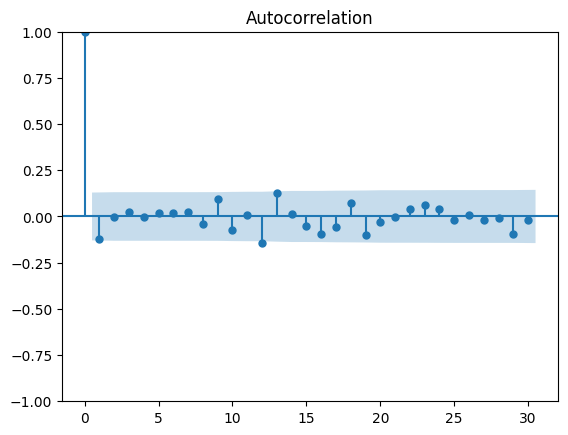

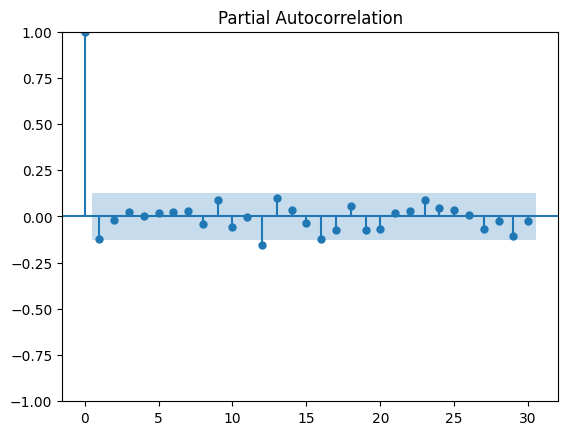

In [472]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["first_diff"].dropna(),lags=30)
plot_pacf(df["first_diff"].dropna(),lags=30)
plt.show()

c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

Date
2024-11-25    273.309998
2024-11-26    280.109985
2024-11-27    284.720001
2024-11-28    286.130005
2024-11-29    279.760010
2024-12-02    282.500000
2024-12-03    279.850006
2024-12-04    286.250000
2024-12-05    299.350006
2024-12-06    302.950012
Name: Close, dtype: float64
Date
2024-11-25    268.105850
2024-11-26    273.026857
2024-11-27    278.812305
2024-11-28    287.063934
2024-11-29    284.299450
2024-12-02    279.591260
2024-12-03    282.332560
2024-12-04    283.257386
2024-12-05    290.188738
2024-12-06    299.627419
Name: predicted_mean, dtype: float64


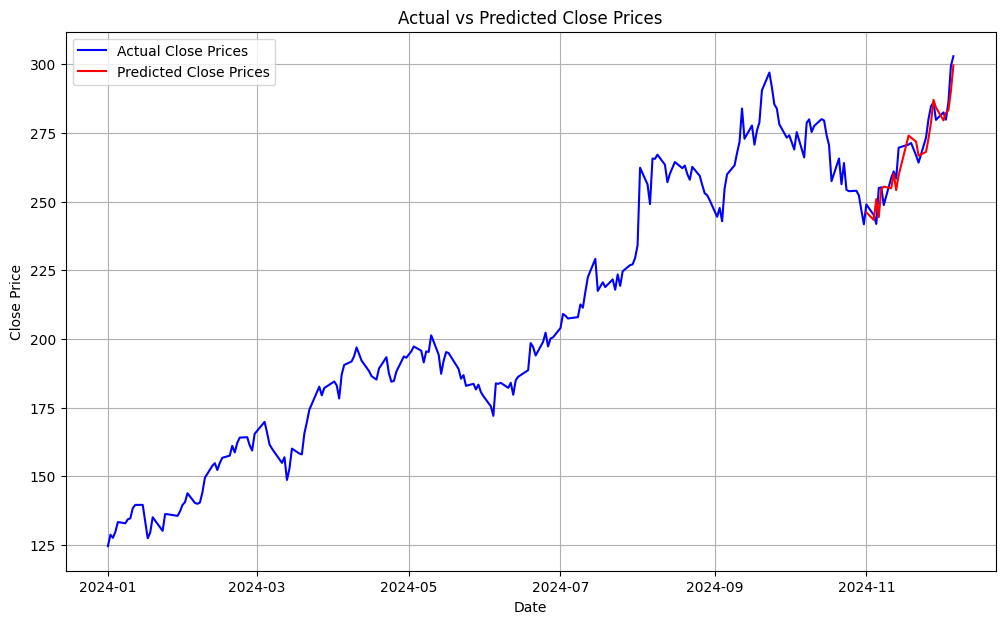

In [473]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')



# ARIMA model
model = ARIMA(df['Close'], order=(12,2,24))
arima_result = model.fit()

# Forecasting
start_date = pd.to_datetime("2024-11-01")  # Adjust the date format
end_date = pd.to_datetime("2024-12-06")

# Ensure start_date and end_date are within the index range
if start_date not in df.index or end_date not in df.index:
    print("The start_date or end_date is not found in the data's index.")
    print(f"Available dates are: {df.index.min()} to {df.index.max()}")
else:
    # Predict the data for the given range
    predicted_data = arima_result.predict(start=start_date, end=end_date, typ='levels')

    # Add predictions to the DataFrame
    df.loc[start_date:end_date, 'Predicted'] = predicted_data
    print(df['Close'].tail(10))
    print(predicted_data.tail(10))
    # Plotting
    plt.figure(figsize=(12, 7))
    plt.plot(df['Close'], label='Actual Close Prices', color='blue')
    plt.plot(df['Predicted'], label='Predicted Close Prices', color='red')
    plt.title('Actual vs Predicted Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    


c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


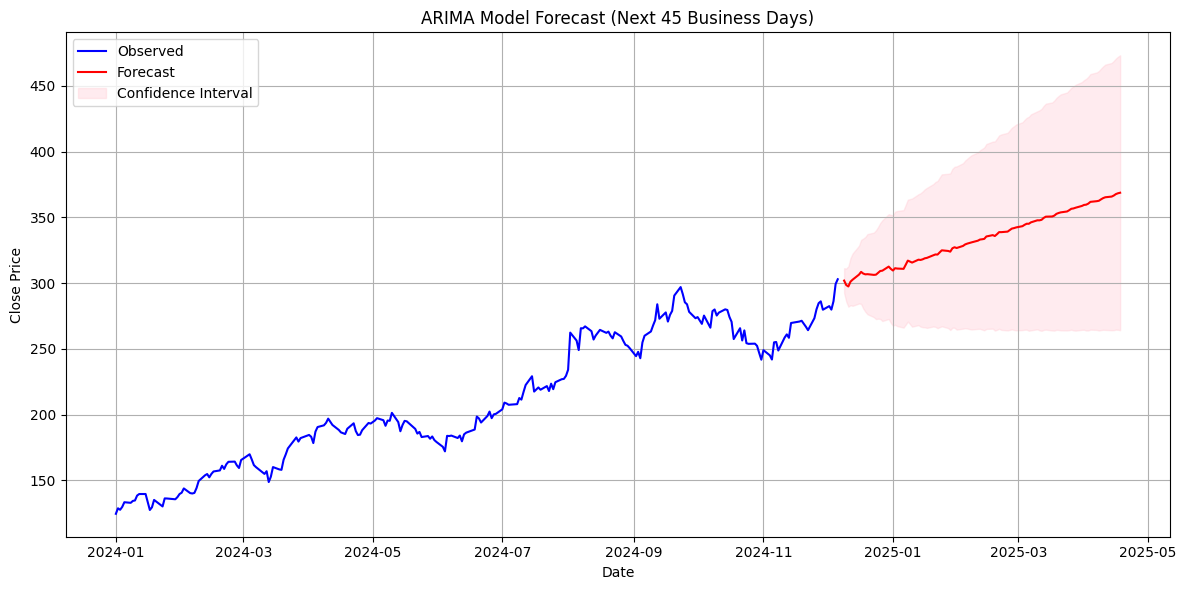

In [474]:
# Forecast the next 45 days
forecast_steps = 95
forecast = arima_result.get_forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Customize the plot
plt.title('ARIMA Model Forecast (Next 45 Business Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [475]:
# Ensure the column exists
'''if 'predicted_data' not in df.columns:
    raise KeyError("The DataFrame does not contain 'predicted_data'. Check your prediction process.")
'''
# Align actual and predicted values
actual = df['Close'].dropna()
predicted = predicted_data.dropna()

# Align indices to ensure comparison
actual = actual.loc[predicted.index]

# Check alignment
if len(actual) != len(predicted):
    raise ValueError("Actual and predicted values have mismatched indices after alignment.")

# Metrics calculations (MAE, RMSE, R², MAPE, accuracy, directional accuracy)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate errors and accuracy
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

# Avoid division by zero in MAPE
actual_nonzero = actual.replace(0, np.nan)
mape = np.mean(np.abs((actual_nonzero - predicted) / actual_nonzero)) * 100
accuracy = 100 - mape if not np.isnan(mape) else 0

# Print results
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.4f}')
print(f'Model Accuracy (100 - MAPE): {accuracy:.2f}%')

# Directional accuracy
actual_direction = np.sign(actual.diff().dropna())
predicted_direction = np.sign(predicted.diff().dropna())

# Align indices
actual_direction = actual_direction.loc[predicted_direction.index]

# Check alignment
if len(actual_direction) != len(predicted_direction):
    raise ValueError("Directional values have mismatched indices after alignment.")

directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
print(f'Directional Accuracy: {directional_accuracy:.2f}%')


Mean Absolute Error (MAE): 4.49
Root Mean Squared Error (RMSE): 5.33
R-squared Score (R²): 0.8914
Model Accuracy (100 - MAPE): 98.32%
Directional Accuracy: 69.57%


In [476]:
import pandas as pd

# Forecast the next 15 business days (or any required period)
forecast_steps = len(forecast_mean)  # Assuming forecast_mean has all the predicted values

# Generate NSE working days starting from the next day after the last index in `df`
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_steps, 
                               freq='B')  # 'B' ensures business days only

# Assign dates to forecast_mean
forecast_mean_with_dates = forecast_mean.copy()
forecast_mean_with_dates.index = forecast_dates  # Set the generated dates as the index
forecast_mean_with_dates = forecast_mean_with_dates.to_frame(name='Predicted Close')
forecast_mean_with_dates['Date'] = forecast_mean_with_dates.index

# Reset index to have a separate 'Date' column if required
forecast_mean_with_dates.set_index('Date', inplace=True)

# Print the updated forecast data
print(forecast_mean_with_dates.head(15))


            Predicted Close
Date                       
2024-12-09       301.914855
2024-12-10       298.542826
2024-12-11       297.447634
2024-12-12       301.105717
2024-12-13       302.616556
2024-12-16       306.465861
2024-12-17       308.549356
2024-12-18       307.271332
2024-12-19       306.680418
2024-12-20       306.808285
2024-12-23       306.270355
2024-12-24       306.429746
2024-12-25       307.821657
2024-12-26       309.216987
2024-12-27       309.466758


In [477]:
import yfinance as yf
import pandas as pd
from datetime import datetime  # For handling dates

# Define the ticker and date range
ticker = 'ZOMATO.NS'
start_date = '2024-12-09'
end_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date as a string

# Download the data
df = yf.download(ticker, start=start_date, end=end_date)

# Convert to a DataFrame
data = pd.DataFrame(df)

# Display the DataFrame
print(data['Close'])
print(forecast_mean_with_dates.head(9))


[*********************100%***********************]  1 of 1 completed

Ticker       ZOMATO.NS
Date                  
2024-12-09  295.299988
2024-12-10  295.850006
2024-12-11  291.799988
2024-12-12  284.899994
2024-12-13  288.250000
2024-12-16  294.149994
2024-12-17  296.799988
2024-12-18  291.899994
2024-12-19  288.500000
            Predicted Close
Date                       
2024-12-09       301.914855
2024-12-10       298.542826
2024-12-11       297.447634
2024-12-12       301.105717
2024-12-13       302.616556
2024-12-16       306.465861
2024-12-17       308.549356
2024-12-18       307.271332
2024-12-19       306.680418


In [478]:
# Directional accuracy: Sign of the difference
actual_direction = np.sign(actual.diff())  # Sign of changes in actual
predicted_direction = np.sign(predicted.diff())  # Sign of changes in predicted

# Align the indices of both series
common_indices = actual_direction.index.intersection(predicted_direction.index)
actual_direction = actual_direction.loc[common_indices]  # Align actual_direction with common indices
predicted_direction = predicted_direction.loc[common_indices]  # Align predicted_direction with common indices

# Check if lengths match after alignment
if len(actual_direction) != len(predicted_direction):
    raise ValueError("Directional values still have mismatched lengths after alignment.")

# Calculate directional accuracy
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
print(f'Directional Accuracy: {directional_accuracy:.2f}%')


Directional Accuracy: 66.67%


In [479]:
# Ensure actual and predicted are aligned and have matching column names
actual = df['Close'].dropna()  # Remove NaN values from actual
predicted = forecast_mean_with_dates.dropna()  # Remove NaN values from predicted

# Rename the predicted column to match the actual column name (if needed)
predicted = predicted.rename(columns={'Predicted Close': 'ZOMATO.NS'})

# Intersect indices to match actual and predicted
common_indices = actual.index.intersection(predicted.index)
actual = actual.loc[common_indices]  # Align actual with common indices
predicted = predicted.loc[common_indices]  # Align predicted with common indices

# Check if lengths match
if len(actual) != len(predicted):
    raise ValueError("Actual and predicted values have mismatched lengths after alignment.")

# Metrics calculations (MAE, RMSE, R², MAPE, accuracy, directional accuracy)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate errors
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

# Avoid division by zero in MAPE: Calculate only for non-zero values of actual
non_zero_indices = actual != 0  # Boolean index for non-zero actual values
mape = np.mean(np.abs((actual[non_zero_indices] - predicted[non_zero_indices]) / actual[non_zero_indices])) * 100

# Calculate accuracy
accuracy = 100 - mape if not np.isnan(mape) else 0

# Print errors and accuracy
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.4f}')
print(f'Model Accuracy (100 - MAPE): {accuracy:.2f}%')




Mean Absolute Error (MAE): 11.46
Root Mean Squared Error (RMSE): 12.51
R-squared Score (R²): -9.8248
Model Accuracy (100 - MAPE): 96.06%


c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Shahuraje\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


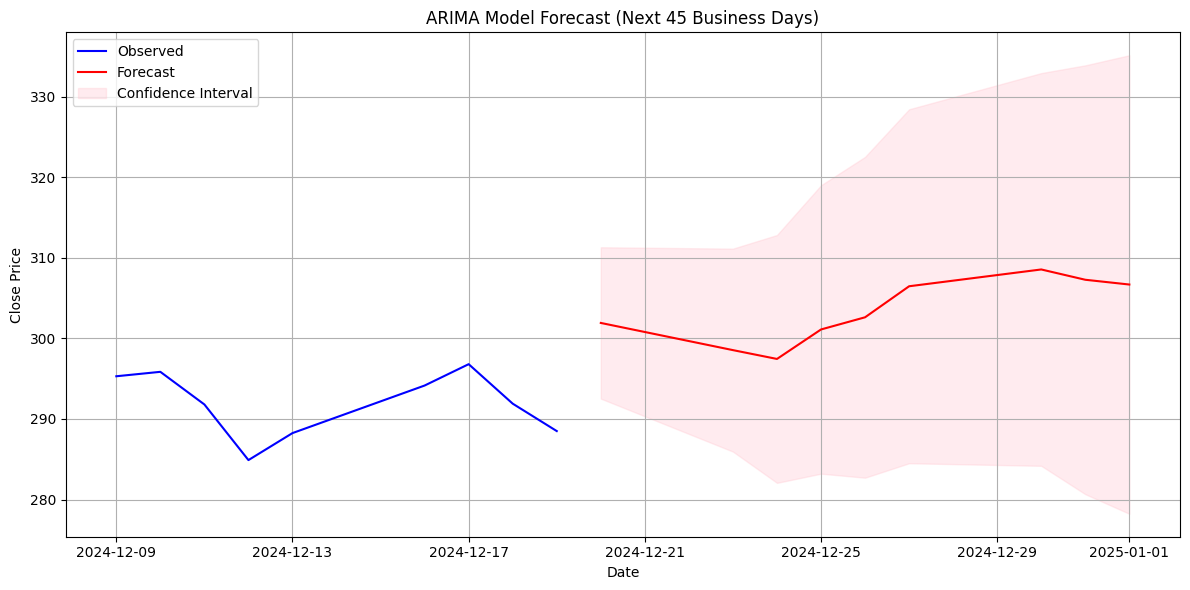

In [480]:
# Forecast the next 45 days
forecast_steps = 9
forecast = arima_result.get_forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the observed data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_ci.iloc[:, 1],  # Upper bound of the confidence interval
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Customize the plot
plt.title('ARIMA Model Forecast (Next 45 Business Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
